## Assignment II: Data Structures and Methods for HPC

# Exercise 1 - Pytest with Julia Set Code

Julia code with assert statement removed and replaced with a return of output for the function.

In [2]:
"""Julia set generator without optional PIL-based image drawing"""
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -0.42193


# decorator to time
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result

    return measure_time


def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    print("the sum is: ", sum(output))

    return output


def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    calc_pure_python(desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 2.6147358417510986 seconds
the sum is:  33219980


Pytest of the function which replaced the assert statment and accounts for multiple test cases and dimensions.

In [3]:
import ipytest
import pytest
ipytest.autoconfig()

In [4]:
%%ipytest -v

@pytest.mark.parametrize('width, iterations, expected', [(1000, 300, 33219980), (10, 3, 177)])
def test_calc_pure_python(width, iterations, expected):
    output = calc_pure_python(width, iterations)
    assert sum(output) == expected

======================================= test session starts ========================================
platform darwin -- Python 3.13.1, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/albinww/Programming/Github/hpc/A2
plugins: anyio-4.8.0
collected 2 items

t_2097b30b43d74bb2b43afb66a8b1fcc6.py ..                                                     [100%]

======================================== 2 passed in 2.80s =========================================


To include unit tests with different numbers or iterations, an expected value is necessary but easily implemented in the above code as another tuple in the list. Add one tuple after the two given cases, right of the (10, 3, 177), and it would be able to test the sum of output given different inputs.

# Exercise 2 - Python DGEMM Benchmark Operation#

### Task 2.1 
Implement the DGEMM with matrices as NumPy array

Original C code:

In [5]:
# // Multiplying first and second matrices and storing it in result
#    for (int i = 0; i < N; ++i) {
#       for (int j = 0; j < N; ++j) {
#          for (int k = 0; k < N; ++k) {
#             C[i][j] = C[i][j] + A[i][k] * B[k][j];
#          }
#       }
#    }

Python translation of the C code:

In [6]:
import numpy as np
import timeit

Uses psudo random number generator to deterministically generate the matrices A, B, and C. 

In [7]:
seed = 1
N = 100
np.random.seed(seed)

A = np.random.randint(-N, N, (N, N))
B = np.random.randint(-N, N, (N, N))
C = np.random.randint(-N, N, (N, N))

# print("A is : \n", A)
# print("B is : \n", B)
# print("C is : \n", C)

Use logging to record the time taken to perform the DGEMM operation.

In [8]:
import logging

# Configure logging
logging.basicConfig(
    format="%(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

In [9]:
def for_loop_matrix_multiplication(A, B, C, N):
    start = timeit.default_timer()
    for i in range(N):
        for j in range(N):
            for k in range(N):
                C[i][j] += A[i][k] * B[k][j]
    end = timeit.default_timer()

    return (C, end - start)


(output, for_loop_matrix_time) = for_loop_matrix_multiplication(A, B, C, N)
logger.info(f"Time taken for normal multiplication: {for_loop_matrix_time}")
# logger.info("Correct is: \n", output)

INFO - Time taken for normal multiplication: 0.40358695900067687


In [10]:
def numpy_matrix_multiplication(A, B, C):
    start = timeit.default_timer()
    C += np.matmul(A, B)
    end = timeit.default_timer()
    return (C, end - start)


(output, np_matrix_time) = numpy_matrix_multiplication(A, B, C)
logger.info(f"Time taken for normal multiplication: {np_matrix_time}")
# logger.info("Correct is: \n", output)

INFO - Time taken for normal multiplication: 0.0010183749836869538


### Task 2.2
Below is the PyTest or IPyTest for the numpy matrix multiplication. The for-loop solution is seen as the correct solution for all cases:

In [11]:
%%ipytest -v

@pytest.mark.parametrize("seed, size", [(1, 10), (1, 50), (1, 100), (2, 10)])
def test_numpy_matrix_multiplication(seed, size):
    N = size
    np.random.seed(seed)
    A = np.random.randint(-N, N, (N, N))
    B = np.random.randint(-N, N, (N, N))
    C = np.random.randint(-N, N, (N, N))

    assert np.array_equal(
        numpy_matrix_multiplication(A, B, C)[0],
        for_loop_matrix_multiplication(A, B, C, N)[0],
    ), f"Mismatch for seed={seed}, size={size}"

======================================= test session starts ========================================
platform darwin -- Python 3.13.1, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/albinww/Programming/Github/hpc/A2
plugins: anyio-4.8.0
collected 4 items

t_2097b30b43d74bb2b43afb66a8b1fcc6.py ....                                                   [100%]

======================================== 4 passed in 0.49s =========================================


Helper matrix generation function:

In [12]:
def matrix_generator(seed, N):
    np.random.seed(seed)
    A = np.random.randint(-N, N, (N, N))
    B = np.random.randint(-N, N, (N, N))
    C = np.random.randint(-N, N, (N, N))
    return (A, B, C)

Timewise comparison of the matrix multiplications:

In [13]:
%%ipytest -v

@pytest.mark.parametrize("seeds, sizes", [((1,2), (10,50))])
def test_matrix_multiplication_performance(seeds, sizes):
    for seed in seeds:
        for N in sizes:
            A, B, C = matrix_generator(seed, N)

            C_numpy, time_numpy = numpy_matrix_multiplication(A, B, C.copy())
            C_loop, time_loop = for_loop_matrix_multiplication(A, B, C.copy(), N)

            logger.info(
                f"Testing for N = {N} with seed = {seed} \n       Numpy-based time: {time_numpy:.6f} seconds \n       For-loop-based time: {time_loop:.6f} seconds \n {"-"*45}"
            )
            
            assert np.array_equal(C_numpy, C_loop), f"Mismatch for seed={seed}, size={N}"

======================================= test session starts ========================================
platform darwin -- Python 3.13.1, pytest-8.3.4, pluggy-1.5.0
rootdir: /Users/albinww/Programming/Github/hpc/A2
plugins: anyio-4.8.0
collected 1 item

t_2097b30b43d74bb2b43afb66a8b1fcc6.py 

INFO - Testing for N = 10 with seed = 1 
       Numpy-based time: 0.000010 seconds 
       For-loop-based time: 0.000416 seconds 
 ---------------------------------------------
INFO - Testing for N = 50 with seed = 1 
       Numpy-based time: 0.000136 seconds 
       For-loop-based time: 0.053733 seconds 
 ---------------------------------------------
INFO - Testing for N = 10 with seed = 2 
       Numpy-based time: 0.000007 seconds 
       For-loop-based time: 0.000398 seconds 
 ---------------------------------------------
INFO - Testing for N = 50 with seed = 2 
       Numpy-based time: 0.000153 seconds 
       For-loop-based time: 0.051235 seconds 
 ---------------------------------------------


.                                                      [100%]

======================================== 1 passed in 0.12s =========================================


### Task 2.3

Timer function from assignment 1 changed from decorator to a function with some added functionality like confidence intervals.

In [14]:
from typing import Callable
import scipy.stats as stats


def timer(N, func: Callable, *args, **kwargs):
    arr = np.zeros((10,))
    result = None
    for n in range(10):
        start = timeit.default_timer()
        result = func(*args, **kwargs)
        end = timeit.default_timer()
        arr[n] = end - start

    mean = np.mean(arr)
    sem = stats.sem(arr)
    confidence = 0.95
    interval = stats.t.interval(confidence, len(arr) - 1, loc=mean, scale=sem)
    interval = (float(interval[0]), float(interval[1]))

    logger.info(
        f"""Function: {func.__name__} {N}x{N}
       Average Execution Time: {mean:.6f} seconds 
       Standard Deviation: {arr.std():.6f} seconds 
       Min/Max: ({arr.min():.6f}, {arr.max():.6f}) seconds 
       95% Confidence Interval: {interval}
        """
    )
    return result


Testing the timer function with the DGEMM functions:

In [15]:
N = 10
seed = 1
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)

N = 100
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)

N = 250
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)


INFO - Function: numpy_matrix_multiplication 10x10
       Average Execution Time: 0.000003 seconds 
       Standard Deviation: 0.000004 seconds 
       Min/Max: (0.000002, 0.000016) seconds 
       95% Confidence Interval: (-9.328933013943694e-08, 6.485095858111658e-06)
        
INFO - Function: for_loop_matrix_multiplication 10x10
       Average Execution Time: 0.000700 seconds 
       Standard Deviation: 0.000173 seconds 
       Min/Max: (0.000401, 0.000941) seconds 
       95% Confidence Interval: (0.0005694853773980041, 0.0008309644131281773)
        
INFO - Function: numpy_matrix_multiplication 100x100
       Average Execution Time: 0.000365 seconds 
       Standard Deviation: 0.000029 seconds 
       Min/Max: (0.000346, 0.000431) seconds 
       95% Confidence Interval: (0.00034293732728786415, 0.0003865544788355416)
        
INFO - Function: for_loop_matrix_multiplication 100x100
       Average Execution Time: 0.396744 seconds 
       Standard Deviation: 0.011594 seconds 
      

### Task 2.4
Through math we can calculate that the expected FLOPS for a matrix multiplication of size n x n is [2n^3](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html). Given this we can simply divide the expected FLOPS by the time taken to get the FLOPS per second of the function.

Redefine the timer function as flops to include the FLOPS per second calculation while excluding unnecessary data:

In [28]:
def FLOPS(N, func: Callable, *args, **kwargs):
    arr = np.zeros((10,))
    for n in range(10):
        start = timeit.default_timer()
        _ = func(*args, **kwargs)
        end = timeit.default_timer()
        arr[n] = end - start

    mean = np.mean(arr)
    flops = 2 * N ** 3
    flops /= mean #
    flops /= 1e9 # GigaFLOPS
    return flops

In [29]:
import matplotlib.pyplot as plt

In [30]:
seed = 1

sizes = [10,50,75,100,125,150,175,200]

numpy_matrix_flops = np.zeros((len(sizes),), dtype=float)
for_loop_matrix_flops = np.zeros((len(sizes),), dtype=float)

for n in range(len(sizes)):
    N = sizes[n]
    A, B, C = matrix_generator(seed, N)
    numpy_matrix_flops[n] = FLOPS(N, numpy_matrix_multiplication, A, B, C)
    for_loop_matrix_flops[n] = FLOPS(N, for_loop_matrix_multiplication, A, B, C, N)

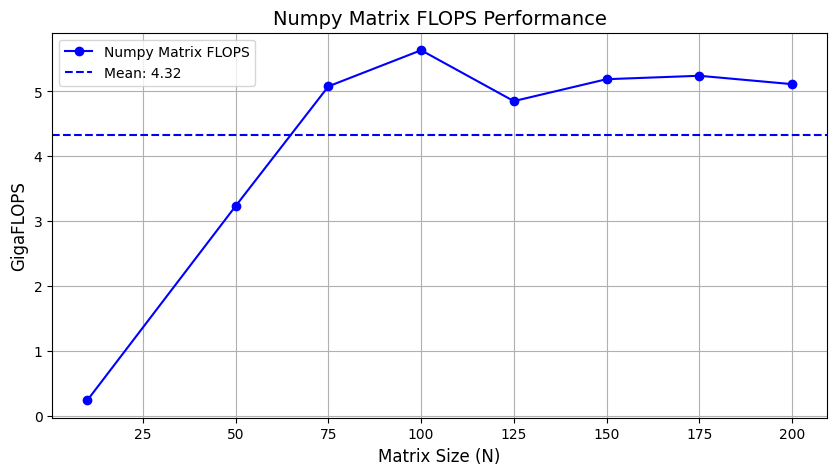

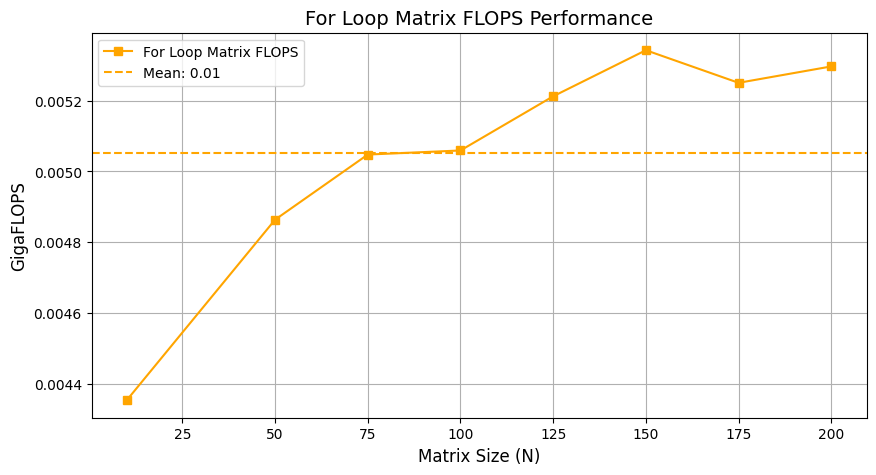

In [31]:
mean_numpy_flops = numpy_matrix_flops.mean()
mean_for_loop_flops = for_loop_matrix_flops.mean()

plt.figure(figsize=(10, 5))
plt.plot(
    sizes, numpy_matrix_flops, marker="o", color="blue", label="Numpy Matrix FLOPS"
)
plt.axhline(
    y=mean_numpy_flops,
    color="blue",
    linestyle="--",
    label=f"Mean: {mean_numpy_flops:.2f}",
)
plt.xlabel("Matrix Size (N)", fontsize=12)
plt.ylabel("GigaFLOPS", fontsize=12)
plt.title("Numpy Matrix FLOPS Performance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(
    sizes,
    for_loop_matrix_flops,
    marker="s",
    color="orange",
    label="For Loop Matrix FLOPS",
)
plt.axhline(
    y=mean_for_loop_flops,
    color="orange",
    linestyle="--",
    label=f"Mean: {mean_for_loop_flops:.2f}",
)
plt.xlabel("Matrix Size (N)", fontsize=12)
plt.ylabel("GigaFLOPS", fontsize=12)
plt.title("For Loop Matrix FLOPS Performance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

There is some uncertainty in the GigaFLOPS calculation for smaller matrices but we can see that the values converge with larger matrices. The theoretical peak performance of my computer (M2 Mac Air) is 3.6 TFLOPs, for the numpy matrix multiplication we are getting around 4.3 GFLOPs which is around 0.12% of the peak performance.

In [34]:
theoretical_peak = 3600 # 3.6 TFLOPs
numpy_utilization = mean_numpy_flops / theoretical_peak
for_loop_utilization = mean_for_loop_flops / theoretical_peak
logger.info(f"Numpy Matrix Utilization: {(numpy_utilization*100):.6f}%")
logger.info(f"For Loop Matrix Utilization: {(for_loop_utilization*100):.6f}%")

INFO - Numpy Matrix Utilization: 0.120089%
INFO - For Loop Matrix Utilization: 0.000140%


## Exercise 3 - Experiment with the Python Debugger